<a href="https://colab.research.google.com/github/AadityaSharma1001/Toxic-Comment-Classification/blob/main/Toxic_Comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.layers import GlobalMaxPooling1D
# Instead of 'keras.preprocessing.text', use 'tensorflow.keras.preprocessing.text'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Fixed typo: pad_sequence to pad_sequences
from tensorflow.keras.optimizers import Adam
# Fixed typo: kergs to keras, also moved vis_utils to utils
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_auc_score

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-11-05 12:57:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-05 12:57:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-05 12:57:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Load pre-trained word vectors into a dictionary
word2vec = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [ ]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
BATCH_SIZE = 128
EPOCHS = 5

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
train_sentences = train['comment_text'].values
train_targets = train.loc[:, 'toxic':].values
print(train_sentences.shape, train_targets.shape)

(159571,) (159571, 6)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [ ]:
test_labels.sample(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
80786,86d727cb97a0922e,0,0,0,0,0,0
1572,02a737ebfa57e252,-1,-1,-1,-1,-1,-1
44100,49221545c6e374c0,-1,-1,-1,-1,-1,-1
78578,831df4f6158e4cff,0,0,0,0,0,0
132848,ddffecbd277a4815,0,0,0,0,0,0
83957,8bfc1652f2bc1c94,-1,-1,-1,-1,-1,-1
97686,a301304c4e789c41,-1,-1,-1,-1,-1,-1
39745,41fc50d53e02baea,-1,-1,-1,-1,-1,-1
60445,6483c95ac8b31252,-1,-1,-1,-1,-1,-1
10237,11205529195a84bb,-1,-1,-1,-1,-1,-1


In [ ]:
invalid_labels = test_labels[test_labels.loc[:, 'toxic'] == -1]
invalid_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89186 entries, 0 to 153163
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             89186 non-null  object
 1   toxic          89186 non-null  int64 
 2   severe_toxic   89186 non-null  int64 
 3   obscene        89186 non-null  int64 
 4   threat         89186 non-null  int64 
 5   insult         89186 non-null  int64 
 6   identity_hate  89186 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.4+ MB


In [ ]:
test_labels.drop(index=invalid_labels.index, inplace=True)
test_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63978 entries, 5 to 153156
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             63978 non-null  object
 1   toxic          63978 non-null  int64 
 2   severe_toxic   63978 non-null  int64 
 3   obscene        63978 non-null  int64 
 4   threat         63978 non-null  int64 
 5   insult         63978 non-null  int64 
 6   identity_hate  63978 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 3.9+ MB


In [ ]:
test.drop(index=invalid_labels.index, inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63978 entries, 5 to 153156
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            63978 non-null  object
 1   comment_text  63978 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [ ]:
test_sentences = test['comment_text'].values
test_targets = test_labels.drop("id", axis=1).values
print(test_sentences.shape, test_targets.shape)

(63978,) (63978, 6)


In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [ ]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [ ]:
test_sentences[0]

'Thank you for understanding. I think very highly of you and would not revert without discussion.'

In [ ]:
test_sequences[0]

[127, 6, 12, 1085, 7, 67, 101, 1092, 3, 6, 4, 47, 14, 360, 175, 137]

In [ ]:
test_sentences[1]

':Dear god this site is horrible.'

In [ ]:
test_sequences[1]

[1050, 559, 13, 293, 8, 3327]

In [ ]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', train_data.shape)
print('Shape of test tensor:', test_data.shape)

Shape of train tensor: (159571, 100)
Shape of test tensor: (63978, 100)


In [ ]:
test_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,  127,    6,   12, 1085,
          7,   67,  101, 1092,    3,    6,    4,   47,   14,  360,  175,
        137], dtype=int32)

In [ ]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
M=15
LABELS = train_targets.shape[1]

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
output = Dense(LABELS, activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)


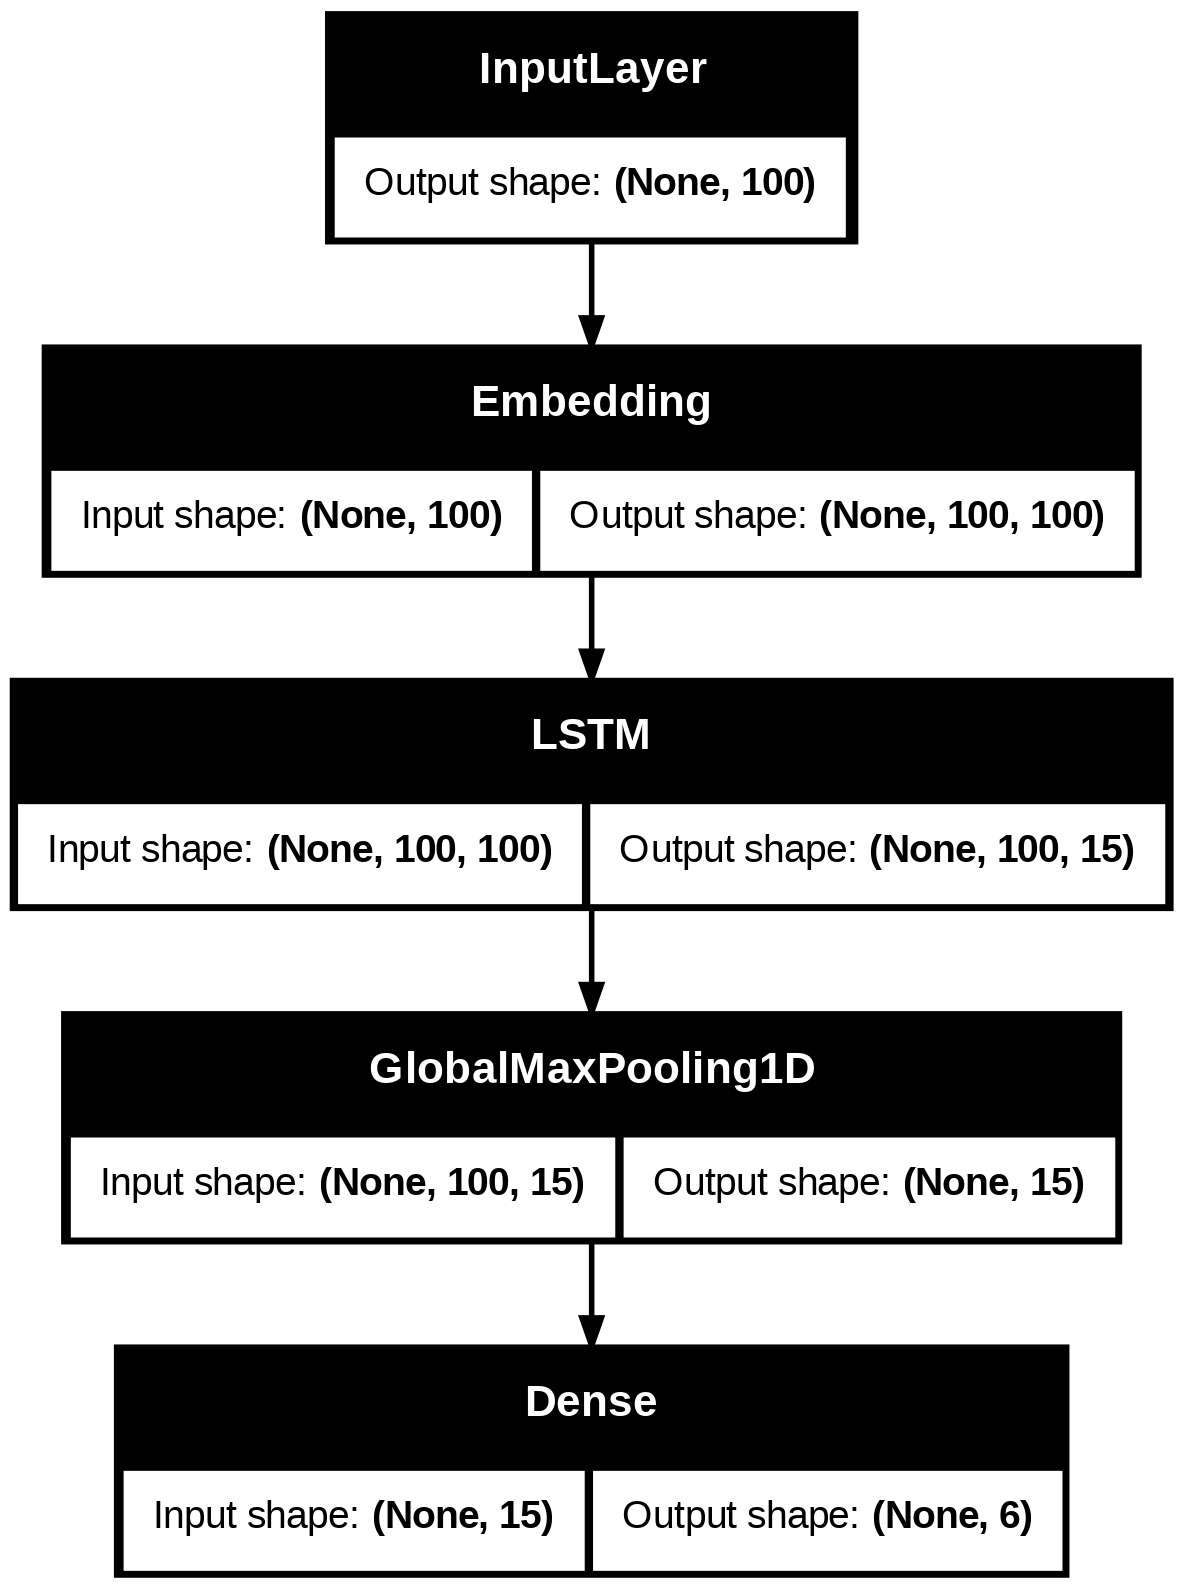

In [ ]:
plot_model(model, show_shapes=True,to_file='model.png')

In [ ]:
print(train_data.shape, test_data.shape, train_targets.shape, test_targets.shape)

(159571, 100) (63978, 100) (159571, 6) (63978, 6)


In [ ]:
r = model.fit(
    train_data,
    train_targets,
    validation_data=(test_data, test_targets),
    epochs=EPOCHS, batch_size=BATCH_SIZE
)

Epoch 1/5
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 117s 90ms/step - accuracy: 0.8942 - loss: 0.1178 - val_accuracy: 0.9909 - val_loss: 0.0763
Epoch 2/5
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 150s 97ms/step - accuracy: 0.9920 - loss: 0.0554 - val_accuracy: 0.9968 - val_loss: 0.0737
Epoch 3/5
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 116s 93ms/step - accuracy: 0.9900 - loss: 0.0519 - val_accuracy: 0.9929 - val_loss: 0.0719
Epoch 4/5
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 144s 95ms/step - accuracy: 0.9898 - loss: 0.0512 - val_accuracy: 0.9918 - val_loss: 0.0777
Epoch 5/5
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 135s 90ms/step - accuracy: 0.9857 - loss: 0.0497 - val_accuracy: 0.9951 - val_loss: 0.0714


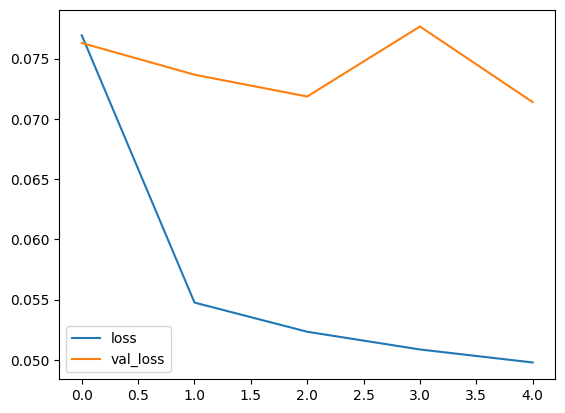

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

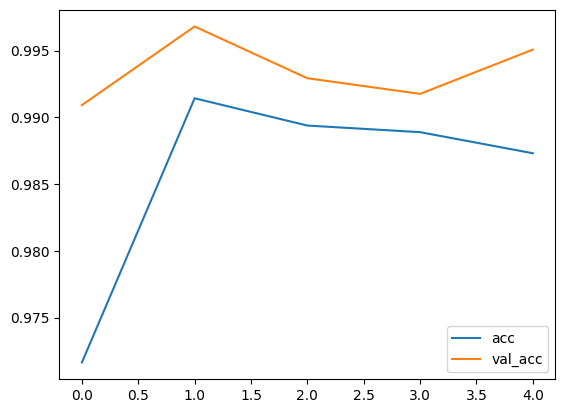

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
test_predictions = model.predict(test_data)
aucs = []
for j in range(LABELS):
    auc = roc_auc_score(test_targets[:,j], test_predictions[:,j])
    aucs.append(auc)
print(np.mean(aucs))

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step
0.970564397257


In [ ]:
pip install gradio jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


In [ ]:
import gradio as gr

def predict_toxicity(text):
    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

    # Get the model's predictions
    predictions = model.predict(padded_sequence)[0]

    # Create a dictionary of labels and predictions
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    result = dict(zip(labels, predictions))

    return result

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_toxicity,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.Label(num_top_classes=6),
    title="Toxicity Prediction",
    description="Enter text to see the predicted toxicity levels for different categories.",
)

# Launch the interface
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7abc7b7b10b2fe2ce9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
